In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
directory = "../input/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/"
fold_0 = pd.read_csv(os.path.join(directory, 'fold_0_data.txt'), sep='\t')
fold_1 = pd.read_csv(os.path.join(directory, 'fold_1_data.txt'),sep='\t')
fold_2 = pd.read_csv(os.path.join(directory, 'fold_2_data.txt'),sep='\t')
fold_3 = pd.read_csv(os.path.join(directory, 'fold_3_data.txt'),sep='\t')
fold_4 = pd.read_csv(os.path.join(directory, 'fold_4_data.txt'),sep='\t')
folds_arr = [fold_0, fold_1, fold_2, fold_3, fold_4]
folds_arr[0].head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [3]:
df = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
print('[+] length of the file:', len(df))
print('[+] unique values of Age:')
print(df.age.unique())
print('===================================================')
print('[+] Number of None Values in Age:')
print(df.age.isna().sum())
print('[+] unique values of Gender:')
print(df.gender.unique())
print('===================================================')
print('[+] Number of nan values in Gender:')
print(df.gender.isna().sum())

[+] length of the file: 19370
[+] unique values of Age:
['(25, 32)' '(38, 43)' '(4, 6)' '(60, 100)' '(15, 20)' '(48, 53)'
 '(8, 12)' '(0, 2)' nan '(38, 48)' '35' '3' '55' '58' '22' '13' '45' '36'
 '23' '(38, 42)' '(8, 23)' '(27, 32)' '57' '56' '2' '29' '34' '42' '46'
 '32']
[+] Number of None Values in Age:
748
[+] unique values of Gender:
['f' 'm' nan 'u']
[+] Number of nan values in Gender:
779


In [4]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]
age_mapping_dict1 = {each[0]: each[1] for each in age_mapping}
age_mapping_dict2 = {'0-2':0, '4-6':1, '8-13':2, '15-20':3, '25-32':4, '38-43':5, '48-53':6, '60+':7}
gender_mapping_dict = {'f':0, 'm':1}

def generate_directory(row):
    return os.path.join(directory, 'faces', str(row['user_id']), f'coarse_tilt_aligned_face.{row["face_id"]}.{row["original_image"]}')

def process(df):
    df = df.dropna(subset=['gender','age'])
    df = df[df['gender'] != 'u']
    df['directory'] = df.apply(generate_directory, axis=1)
    df = df[['directory', 'age', 'gender']]
    df['gender'] = df['gender'].map(gender_mapping_dict)
    df['age'] = df['age'].map(age_mapping_dict1)
    df['age'] = df['age'].map(age_mapping_dict2)
    return df
folds_arr = [process(df) for df in folds_arr]
folds_arr[0].head()

,directory,age,gender
0,../input/adience-benchmark-gender-and-age-clas...,4,0
1,../input/adience-benchmark-gender-and-age-clas...,4,1
2,../input/adience-benchmark-gender-and-age-clas...,4,0
3,../input/adience-benchmark-gender-and-age-clas...,4,1
4,../input/adience-benchmark-gender-and-age-clas...,4,1


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((227, 227)) # Same hyperparameter as the paper "Age and Gender Classification using Convolutional Neural Networks"
])

class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = cv2.imread(self.df.iloc[idx,0])
        img = self.transform(img)
        age = torch.tensor(self.df.iloc[idx,1])
        gender = torch.tensor(self.df.iloc[idx,2])
        return img, age, gender

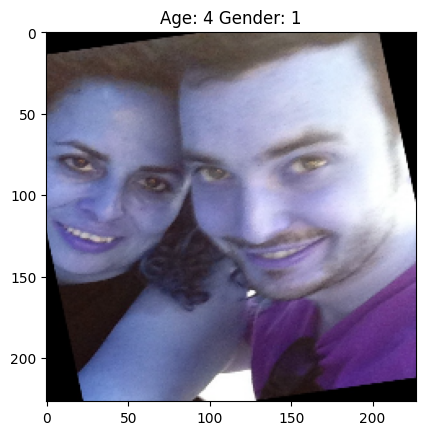

In [6]:
dataset_temp = CustomDataset(folds_arr[0], transform=transform)
dataloader_temp = DataLoader(dataset_temp, batch_size=16, shuffle=True)

data_iter = iter(dataloader_temp)
image, label_age, label_gender = next(data_iter)

plt.imshow(image[0].permute(1, 2, 0))
plt.title(f'Age: {label_age[0]} Gender: {label_gender[0]}')
plt.show()

In [7]:
# Build Model
class GenderCNNModel(nn.Module):
    def __init__(self, num_of_kernels):
        super(GenderCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, num_of_kernels, 3, stride=1)
        self.p1 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(num_of_kernels, 64, 3, stride=1) 
        self.p2 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1)
        self.p3 = nn.MaxPool2d(2, 2)  # Max pooling over a (2, 2) window
        self.flatten = nn.Flatten()
        self.d1 = nn.Linear(128 * 26 * 26, 256)
        self.d2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.2)
        self.outputGender = nn.Linear(128, 1)
        
    def forward(self, x):
        conv1 = torch.relu(self.conv1(x))
        p1 = self.p1(conv1)
        conv2 = torch.relu(self.conv2(p1))
        p2 = self.p2(conv2)
        conv3 = torch.relu(self.conv3(p2))
        p3 = self.p3(conv3)
        flatten = self.flatten(p3)
        d1 = torch.relu(self.d1(flatten))
        dropout1 = self.dropout(d1)
        d2 = torch.relu(self.d2(dropout1))
        dropout2 = self.dropout(d2)
        out = torch.sigmoid(self.outputGender(dropout2))
        return out

In [8]:
def getDataLoaders(i, folds_arr, batch_size):
    
    folds_arr_copy = folds_arr.copy()
    val_dataset = CustomDataset(df=folds_arr_copy[i], transform=transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    
    folds_arr_copy.pop(i)
    df_temp = pd.concat(folds_arr_copy, ignore_index=True)
    train_dataset = CustomDataset(df=df_temp, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, val_dataloader

In [9]:
def train(model, train_dataloader, val_dataloader, num_epochs):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use the Adam optimizer
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    
    for epoch in range(num_epochs):
        model.train()  # Set the model in training mode
        
        train_losses = 0
        output_wrong = 0
        num_batches = len(train_dataloader)
        size = len(train_dataloader.dataset)
        
        for i, data in enumerate(train_dataloader):
            inputs, _, labels = data
            labels = labels.unsqueeze(1).float()
            optimizer.zero_grad()  # Zero the parameter gradients
            
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            
            # Print statistics
            train_losses += loss.item()
            output_wrong += torch.sum(torch.not_equal(outputs > 0.5, labels)) 
        
        train_losses /= num_batches
        train_correct = (size - output_wrong)/size # Calculate the accuracy  
        
        train_acc.append(train_correct)
        train_loss.append(train_losses)
        
        val_losses = 0
        output_wrong = 0
        num_batches = len(val_dataloader)
        size = len(val_dataloader.dataset)
        
        for i, data in enumerate(val_dataloader):
            size = len(val_dataloader.dataset)
            inputs, _, labels = data
            labels = labels.unsqueeze(1).float()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Print statistics
            val_losses += loss.item()
            output_wrong += torch.sum(torch.not_equal(outputs > 0.5, labels))
        
        val_losses /= num_batches
        val_correct = (size - output_wrong)/size # Calculate the accuracy  
        
        val_acc.append(val_correct)
        val_loss.append(val_losses)
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {train_correct:.2f}, Val Accuracy: {val_correct:.2f}')
        
    return train_acc, train_loss, val_acc, val_loss

In [10]:
batch_size = 128
    
def CV_num_of_kernel(num_of_kernel):
    accuracies = []
    print("Training with number of kernels:", num_of_kernel)
    for i in range (5):
        model = GenderCNNModel(num_of_kernel)
        train_dataloader, val_dataloader = getDataLoaders(i, folds_arr, batch_size)
        train_acc, train_loss, val_acc, val_loss = train(model, train_dataloader, val_dataloader, 5)
        accuracies.append(val_acc[4])
    return accuracies

In [11]:
num_of_kernel_64_accuracies = CV_num_of_kernel(64)
num_of_kernel_64_CV = pd.DataFrame({'val_accuracy': num_of_kernel_64_accuracies})
num_of_kernel_64_CV.to_csv('/kaggle/working/num_of_kernel_64.csv',index=False)

Training with number of kernels: 64
Epoch [1/5], Train Accuracy: 0.63, Val Accuracy: 0.67
Epoch [2/5], Train Accuracy: 0.74, Val Accuracy: 0.71
Epoch [3/5], Train Accuracy: 0.79, Val Accuracy: 0.74
Epoch [4/5], Train Accuracy: 0.82, Val Accuracy: 0.77
Epoch [5/5], Train Accuracy: 0.85, Val Accuracy: 0.79
Epoch [1/5], Train Accuracy: 0.63, Val Accuracy: 0.70
Epoch [2/5], Train Accuracy: 0.76, Val Accuracy: 0.74
Epoch [3/5], Train Accuracy: 0.82, Val Accuracy: 0.73
Epoch [4/5], Train Accuracy: 0.86, Val Accuracy: 0.77
Epoch [5/5], Train Accuracy: 0.90, Val Accuracy: 0.75
Epoch [1/5], Train Accuracy: 0.65, Val Accuracy: 0.66
Epoch [2/5], Train Accuracy: 0.74, Val Accuracy: 0.70
Epoch [3/5], Train Accuracy: 0.79, Val Accuracy: 0.71
Epoch [4/5], Train Accuracy: 0.83, Val Accuracy: 0.74
Epoch [5/5], Train Accuracy: 0.86, Val Accuracy: 0.74
Epoch [1/5], Train Accuracy: 0.65, Val Accuracy: 0.71
Epoch [2/5], Train Accuracy: 0.73, Val Accuracy: 0.73
Epoch [3/5], Train Accuracy: 0.78, Val Accurac

In [12]:
num_of_kernel_64_CV

,val_accuracy
0,tensor(0.7950)
1,tensor(0.7467)
2,tensor(0.7439)
3,tensor(0.7833)
4,tensor(0.7829)
